# RealNVP

## RealNVP
NICEを先行研究に、より高性能な Flow base Model を提案した。

Coupling Layer と呼ばれる Flow で主題となるヤコビアンの計算できる関数で、これを提案したことが 1st Contribution.

## Coupling Layer
Coupling Layer は次のような変換を行う。

### Forward
\begin{eqnarray*}
x_{1:d}, x_{d+1:D} &=& split(x) \\
y_{1:d}&=&x_{1:d} \\
y_{d+1:D}&=&s \odot x_{d+1:D} + t \\
y &=& concat(y_{1:d}, y_{d+1:D}) \\
where && \log{s}, t = NN(x_{1:d}) \\
\end{eqnarray*}

### Inverse
\begin{eqnarray*}
y_{1:d}, y_{d+1:D} &=& split(y) \\
x_{1:d}&=&y_{1:d} \\
x_{d+1:D}&=& (y_{d+1:D} - t) / s \\
x &=& concat(x_{1:d},x_{d+1:D}) \\
where && \log{s}, t = NN(y_{1:d}) \\
\end{eqnarray*}

### Forward Jacobian

まずヤコビ行列を求める。
\begin{eqnarray*}
\frac{\partial y}{\partial x}
 = 
\begin{bmatrix}
\frac{\partial y_{1:d}}{\partial x_{1:d}} & \frac{\partial y_{1:d}}{\partial x_{d+1:D}} \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}} & \frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}
\end{bmatrix}
=
\begin{bmatrix}
\mathbb{I}_d & 0 \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}} & diag(s)
\end{bmatrix}
\end{eqnarray*}

ヤコビアンはヤコビ行列の行列式である。
三角行列の行列式は対角成分の積であるから、

\begin{eqnarray*}
det|\cfrac{dy}{dx}| = \Pi{s}
\end{eqnarray*}

ヤコビアンは一般に絶対値を付けられる値で、計算の都合上これを対数で表現すると

\begin{eqnarray*}
\log{|det|\cfrac{dy}{dx}||} = \Sigma{|s|}
\end{eqnarray*}

### Inverse Jacobian

同様にヤコビ行列を求める。
\begin{eqnarray*}
\frac{\partial y}{\partial x}
 = 
\begin{bmatrix}
\frac{\partial x_{1:d}}{\partial y_{1:d}} & \frac{\partial x_{1:d}}{\partial y_{d+1:D}} \\
\frac{\partial x_{d+1:D}}{\partial y_{1:d}} & \frac{\partial x_{d+1:D}}{\partial y_{d+1:D}}
\end{bmatrix}
=
\begin{bmatrix}
\mathbb{I}_d & 0 \\
\frac{\partial x_{d+1:D}}{\partial y_{1:d}} & diag(\frac{y_{1:d}}{\log{s}})
\end{bmatrix}
\end{eqnarray*}

同様に

\begin{eqnarray*}
\log{|det|\cfrac{dx}{dy}||} = - \Sigma{|s|}
\end{eqnarray*}

## 問題設定
2次元の Double Moon 分布から 2次元の多変量標準正規分布(2変量標準正規分布) との変換を行います。

ref [PyTorchでRealNVP](https://qiita.com/cross32768/items/87036cc35c5367050b04)

## Tensorflow を用いて解く

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


### 2変量正規分布の作成

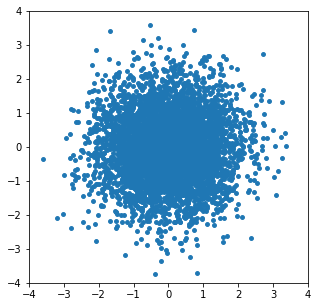

In [2]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
mvn_samples = mvn.sample(5000)
plt.figure(figsize=(5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(mvn_samples[:, 0], mvn_samples[:, 1], s=15)

### Double Moon 分布の作成

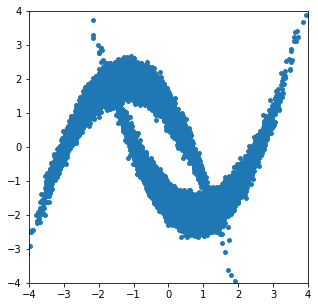

In [3]:
def gen_double_moon_samples(num_samples):
    assert num_samples % 2 == 0, "[Requirement] num_samples % 2 == 0"
    x1_1 = tfd.Normal(loc=4.0, scale=4.0)
    x1_1_samples = x1_1.sample(num_samples // 2)
    x1_2 = tfd.Normal(
        loc=0.25 * (x1_1_samples - 4) ** 2 - 20, 
        scale=tf.ones_like(num_samples / 2) * 2
    )
    x1_2_samples = x1_2.sample()

    x2_1 = tfd.Normal(loc=4.0, scale=4.0)
    x2_1_samples = x2_1.sample(num_samples // 2)
    x2_2 = tfd.Normal(
        loc=-0.25 * (x2_1_samples - 4) ** 2 + 20,
        scale=tf.ones_like(num_samples / 2) * 2,
    )
    x2_2_samples = x2_2.sample()
    
    x1_samples = tf.stack([x1_1_samples * 0.2, x1_2_samples * 0.1], axis=1)
    x2_samples = tf.stack([x2_1_samples * 0.2 - 2, x2_2_samples * 0.1], axis=1)

    x_samples = tf.concat([x1_samples, x2_samples], axis=0)
    return x_samples


base_samples = gen_double_moon_samples(50000)
base_samples = tf.random.shuffle(base_samples)

plt.figure(figsize=(5, 5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(base_samples[:, 0], base_samples[:, 1], s=15)

### データセットの作成

data samples:  10000


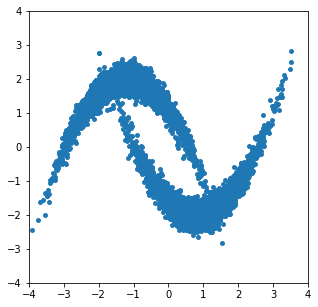

In [4]:
SHUFFLE_BUFFER_SIZE = 10000
BATCH_SIZE = 10000
train_dataset = (
    tf.data.Dataset.from_tensor_slices(base_samples)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

for i in train_dataset.take(1):
    print('data samples: ', len(i))
    plt.figure(figsize=(5, 5))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.scatter(i[:, 0], i[:, 1], s=15)

### NN レイヤーの作成

In [5]:
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, ReLU
from tensorflow.keras import Model


class NN(Layer):
    def __init__(self, input_shape, n_hidden=[512, 512], activation="relu", name="nn"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, hidden in enumerate(n_hidden):
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_1'.format(i)))
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_2'.format(i)))
        self.layer_list = layer_list
        self.log_s_layer = Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t
    


def nn_test():
    nn = NN(1, [512, 512])
    x = tf.keras.Input([1])
    log_s, t = nn(x)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s, t], name="nn_test").summary()
nn_test()

Model: "nn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
nn (NN)                      ((None, 1), (None, 1))    790018    
Total params: 790,018
Trainable params: 790,018
Non-trainable params: 0
_________________________________________________________________


In [6]:
nn = NN(1, [512, 512])
x = tf.random.normal([100, 1])
with tf.GradientTape() as t:
    t.watch(x)
    y = nn(x)
    loss = - tf.reduce_mean(y - x)
optimizer = tf.optimizers.Adam(learning_rate=0.0001) 
grads = t.gradient(loss, nn.trainable_variables)
optimizer.apply_gradients(zip(grads, nn.trainable_variables))
print(loss)

tf.Tensor(0.097440206, shape=(), dtype=float32)


### RealNVP レイヤーの作成

In [15]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        # this bijector do vector wise quantities.
        forward_min_event_ndims=1,
        validate_args: bool = False,
        name="real_nvp",
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
                          
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name="nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s


def realnvp_test():
    realnvp = RealNVP(input_shape=[2], n_hidden=[512, 512])
    x = tf.keras.Input([2])
    y = realnvp.forward(x)
    print('trainable_variables :', len(realnvp.trainable_variables))
    Model(x, y, name="realnvp_test").summary()


realnvp_test()

trainable_variables : 12
Model: "realnvp_test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 1), (None, 1 0           input_9[0][0]                    
__________________________________________________________________________________________________
nn (Model)                      [(None, 1), (None, 1 790018      tf_op_layer_split_1[0][1]        
__________________________________________________________________________________________________
tf_op_layer_Exp_1 (TensorFlowOp [(None, 1)]          0           nn[1][0]                         
______________________________________________________________

### TransformedDistribution の作成

In [16]:
num_realnvp = 4
bijector_chain = []
for i in range(num_realnvp):
    bijector_chain.append(RealNVP(input_shape=[2], n_hidden=[256, 256]))
    bijector_chain.append(tfp.bijectors.Permute([1, 0]))

flow = tfd.TransformedDistribution(
    distribution=mvn,
    bijector=tfb.Chain(list(reversed(bijector_chain)))
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

trainable_variables:  48


### 学習前のサンプリング結果

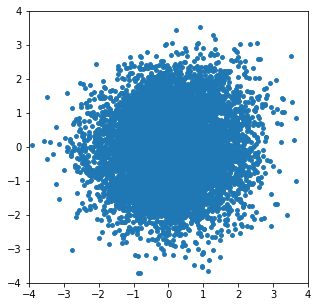

In [17]:
samples = flow.sample(10000)
plt.figure(figsize=(5, 5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(samples[:, 0], samples[:, 1], s=15)

tf.Tensor(-35.19041, shape=(), dtype=float32)
tf.Tensor(-4.382125, shape=(), dtype=float32)
(10000, 10000)


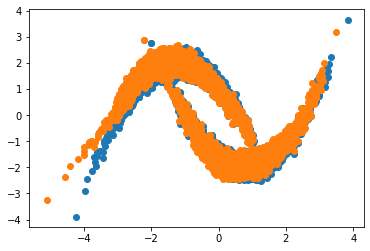

In [18]:
for targets in train_dataset.take(1):
    targets = targets
#print(flow.bijector.inverse(targets))
print(tf.reduce_sum(flow.bijector.inverse_log_det_jacobian(targets, event_ndims=1)))
res = flow.bijector.inverse(targets)
print(tf.reduce_mean(flow.log_prob(res)))
print(flow.log_prob(res).shape)
targets.shape
plt.scatter(targets[:,0], targets[:,1])
plt.scatter(res[:, 0], res[:,1])

### 学習

In [19]:
!rm -r checkpoints

In [20]:
@tf.function
def loss(targets):
    return - tf.reduce_mean(flow.log_prob(targets))


optimizer = tf.optimizers.Adam(learning_rate=0.001) 
log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [21]:
n_epochs = 200

for epoch in range(n_epochs):
    for targets in train_dataset:
        with tf.GradientTape() as tape:
            log_prob_loss = loss(targets)
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            with log.as_default():
                tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
                print(
                    "Step {} Loss {:.6f}".format(
                        optimizer.iterations, avg_loss.result()
                    )
                )
                avg_loss.reset_states()

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss 1.837895


## 推論

### 順方向

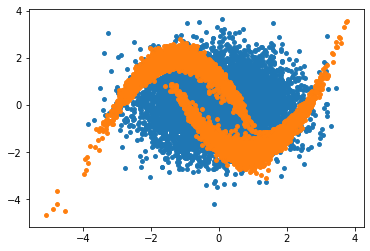

In [26]:
base = flow.distribution.sample(10000)
targets = flow.sample(10000)
plt.scatter(base[:, 0], base[:, 1], s=15)
plt.scatter(targets[:, 0], targets[:, 1], s=15)

### 逆方向 

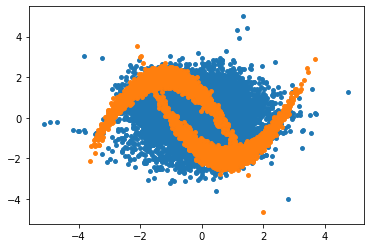

In [25]:
targets = gen_double_moon_samples(10000)
base = flow.bijector.inverse(targets)
targets.shape
plt.scatter(base[:, 0], base[:,1], s=15)
plt.scatter(targets[:,0], targets[:,1], s=15)